In [1]:
import os
import pandas as pd
import numpy as np
from stock_reader import reader
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error
import logging
import os
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Flatten
from keras.layers import GRU
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints
from keras.engine.input_layer import Input
from keras import backend as K
from keras.models import Model

Using TensorFlow backend.


In [75]:
from tensorflow import set_random_seed
set_random_seed(7)
np.random.seed(7)

In [41]:
look_back = 1

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [4]:
# https://www.kaggle.com/qqgeogor/keras-lstm-attention-glove840b-lb-0-043
class Attention(Layer):
    
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim


Enter Code or Symbol :  005930
Enter start date(YYYY-MM--DD) :  20070101
Enter end date(YYYY-MM--DD) :  20200101



     Symbol  Name          Sector
952  005930  삼성전자  통신 및 방송 장비 제조업

             open   high    low  close    volume    change
Date                                                      
2007-01-02  12400  12540  12320  12500    355265  0.019576
2007-01-03  12540  12560  12220  12220    394730 -0.022400
2007-01-04  12220  12240  12060  12140    381464 -0.006547
2007-01-05  12160  12180  11900  11900    586649 -0.019769
2007-01-08  11840  11880  11580  11640    682494 -0.021849
...           ...    ...    ...    ...       ...       ...
2019-12-23  56100  56400  55100  55500   9839252 -0.008929
2019-12-24  55600  55700  54800  55000  11868463 -0.009009
2019-12-26  54700  55400  54400  55400   9645034  0.007273
2019-12-27  55700  56900  55500  56500  12313056  0.019856
2019-12-30  56200  56600  55700  55800   8356767 -0.012389

[3210 rows x 6 columns]


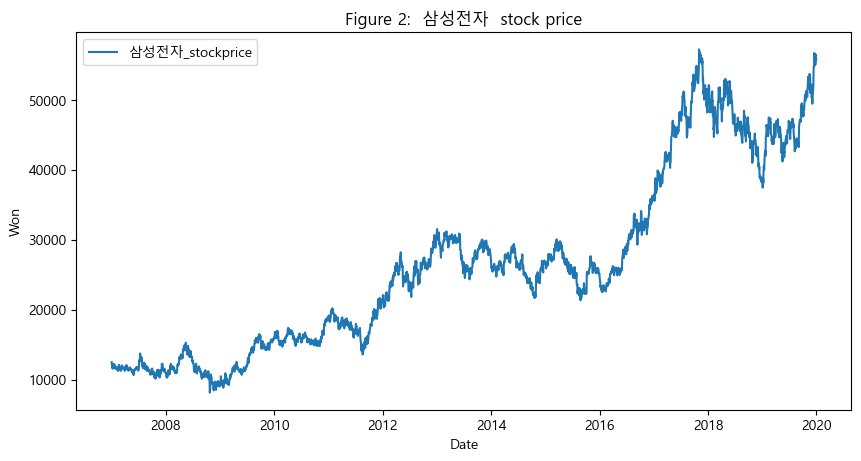


There are 3210 number of days in the dataset.



In [5]:
if __name__ == '__main__':
    stock_code = '005930'  # 삼성전자

    # 주식 데이터 준비
    pandf = reader()

    # 기간 필터링
#    pandf = chart_data[(chart_data['date'] >= '2010-11-01') &
#                                  (chart_data['date'] <= '2017-12-31')]
#    pandf = pandf.dropna()
    # convert nparray
    nparr = pandf['close'].values[::-1].reshape(-1,1)
    nparr.astype('float32')

In [50]:
    nparr = pandf['close'].values[::].reshape(-1,1)
    nparr.astype('float32')
    nptf1=np.array(pandf)
    print(nptf1)
    print("nparr :",nparr.shape,"nptf1 :",nptf1.shape)
    

[[ 1.24000000e+04  1.25400000e+04  1.23200000e+04  1.25000000e+04
   3.55265000e+05  1.95758564e-02]
 [ 1.25400000e+04  1.25600000e+04  1.22200000e+04  1.22200000e+04
   3.94730000e+05 -2.24000000e-02]
 [ 1.22200000e+04  1.22400000e+04  1.20600000e+04  1.21400000e+04
   3.81464000e+05 -6.54664484e-03]
 ...
 [ 5.47000000e+04  5.54000000e+04  5.44000000e+04  5.54000000e+04
   9.64503400e+06  7.27272727e-03]
 [ 5.57000000e+04  5.69000000e+04  5.55000000e+04  5.65000000e+04
   1.23130560e+07  1.98555957e-02]
 [ 5.62000000e+04  5.66000000e+04  5.57000000e+04  5.58000000e+04
   8.35676700e+06 -1.23893805e-02]]
nparr : (3210, 1) nptf1 : (3210, 6)


In [70]:
    # normalization
    scaler = MinMaxScaler(feature_range=(0, 1))
#    nptf = scaler.fit_transform(nparr)
    nptf = scaler.fit_transform(nparr)
    print(nptf.shape)

    # split train, test
    train_size = int(len(nptf) * 0.9)
    test_size = len(nptf) - train_size
    train, test = nptf[0:train_size], nptf[train_size:len(nptf)]
    print(len(train), len(test))

    # create dataset for learning
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    print("trainX :",trainX.shape,"trainY :",trainY.shape,"testX :",testX.shape,"testY :",testY.shape)
    

    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[2])) # trainX.shape[1] --> [2] 로 바꿈 )
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[2]))

(3210, 1)
2889 321
trainX : (2887, 1, 1) trainY : (2887, 1) testX : (319, 1, 1) testY : (319, 1)


In [71]:
    # simple lstm network learning
    model = Sequential()
    model.add(LSTM(128,  return_sequences=True, activation="relu", input_shape=(1, look_back))) # input_shape=(1, look_back) --> (X_train.shape[1], X_train.shape[2]) 
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Attention(look_back))
#    model.add(LSTM(128,  return_sequences=False, activation="relu", input_shape=(1, look_back)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(1, activation="sigmoid"))
    #model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mae'])
    model.summary()
    
    
    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 1, 128)            66560     
_________________________________________________________________
dropout_13 (Dropout)         (None, 1, 128)            0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 1, 128)            512       
_________________________________________________________________
attention_7 (Attention)      (None, 128)               129       
_________________________________________________________________
batch_normalization_14 (Batc (None, 128)               512       
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total para

In [72]:
    from keras.callbacks import EarlyStopping
    early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1) # early_stop 
    model.fit(trainX, trainY, epochs=40, batch_size=32, verbose=2)

    # make prediction
    testPredict = model.predict(testX)
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform(testY)
    testScore = math.sqrt(mean_squared_error(testY, testPredict))
    print('Train Score: %.2f RMSE' % testScore)

    # predict last value (or tomorrow?)
    lastX = nptf[-1]
    lastX = np.reshape(lastX, (1, 1, 1))
    lastY = model.predict(lastX)
    lastY = scaler.inverse_transform(lastY)
    print('Predict the Close value of final day: %d' % lastY)  # 데이터 입력 마지막 다음날 종가 예측


Epoch 1/40
 - 2s - loss: 0.0305 - mean_absolute_error: 0.1266
Epoch 2/40
 - 1s - loss: 0.0114 - mean_absolute_error: 0.0807
Epoch 3/40
 - 1s - loss: 0.0066 - mean_absolute_error: 0.0609
Epoch 4/40
 - 1s - loss: 0.0049 - mean_absolute_error: 0.0537
Epoch 5/40
 - 1s - loss: 0.0038 - mean_absolute_error: 0.0463
Epoch 6/40
 - 1s - loss: 0.0033 - mean_absolute_error: 0.0435
Epoch 7/40
 - 1s - loss: 0.0039 - mean_absolute_error: 0.0474
Epoch 8/40
 - 1s - loss: 0.0037 - mean_absolute_error: 0.0466
Epoch 9/40
 - 1s - loss: 0.0032 - mean_absolute_error: 0.0431
Epoch 10/40
 - 1s - loss: 0.0033 - mean_absolute_error: 0.0442
Epoch 11/40
 - 1s - loss: 0.0038 - mean_absolute_error: 0.0482
Epoch 12/40
 - 1s - loss: 0.0028 - mean_absolute_error: 0.0404
Epoch 13/40
 - 1s - loss: 0.0029 - mean_absolute_error: 0.0418
Epoch 14/40
 - 1s - loss: 0.0033 - mean_absolute_error: 0.0435
Epoch 15/40
 - 1s - loss: 0.0030 - mean_absolute_error: 0.0416
Epoch 16/40
 - 1s - loss: 0.0030 - mean_absolute_error: 0.0416
E

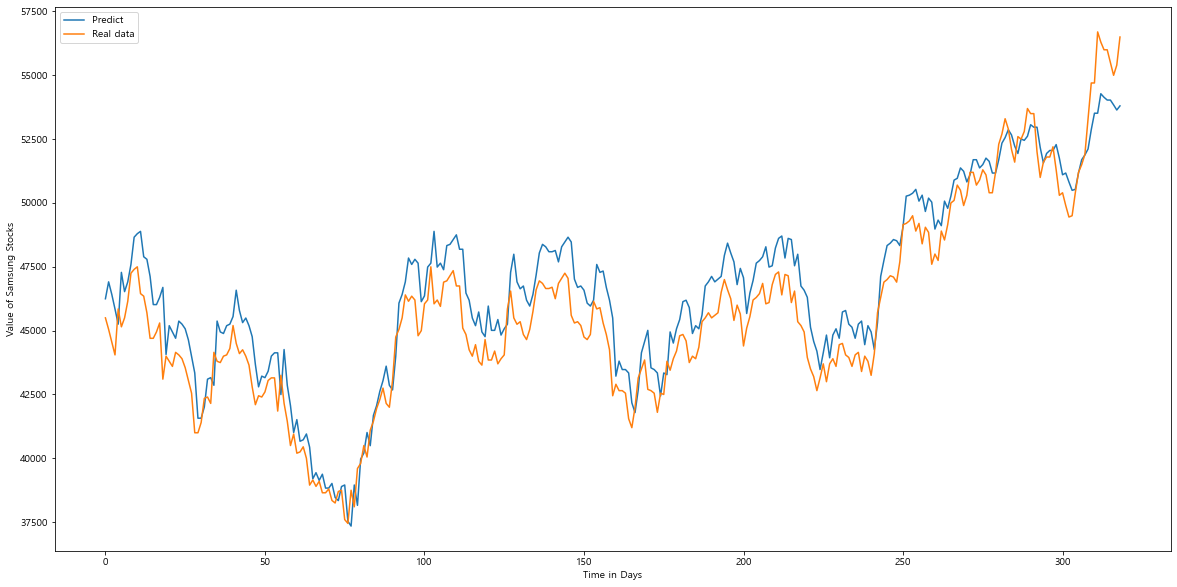

In [73]:
# plot
    plt.rcParams["figure.figsize"] = (20,10)
    plt.plot(testPredict, label = 'Predict')
    plt.plot(testY, label = 'Real data')
    plt.xlabel('Time in Days')
    plt.ylabel('Value of Samsung Stocks')
    plt.legend(loc = 'upper left')
    plt.show()

In [56]:
from sklearn.externals import joblib 
# 객체를 pickled binary file 형태로 저장한다 
file_name = '1scale.pkl' 
joblib.dump(scaler, file_name) 

['1scale.pkl']

In [57]:
from keras.models import load_model
model.save('1SAMSUNGLSTM.h5')

In [61]:
ys=joblib.load('1scale.pkl')
LSTM = load_model('1SAMSUNGLSTM.h5') #어텐션을 저장을 못함

ValueError: Unknown layer: Attention

In [59]:
# make prediction
tp = LSTM.predict(testX)
tp = ys.inverse_transform(tp)

AttributeError: type object 'LSTM' has no attribute 'predict'

In [ ]:

# plot
plt.rcParams["figure.figsize"] = (15,10)
#plt.plot(testPredict)
plt.plot(testY)
plt.plot(tp)
plt.show()